# Imports

In [2]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import BertTokenizer

# Utility
import tensorflow as tf
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Read data

## Amazon Dataset

In [3]:
df_amazon = pd.read_csv('Amazon reviews/train.csv')
print(df_amazon.shape)
df_amazon.columns = ['label', 'review_title', 'text']

(3599999, 3)


In [4]:
df_amazon.head()

,label,review_title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [5]:
df_amazon['label'] = df_amazon['label'].replace({1: 0, 2: 1})

In [6]:
df_title = df_amazon.drop(['text'], axis=1)

In [7]:
df_title.head()

,label,review_title
0,1,The best soundtrack ever to anything.
1,1,Amazing!
2,1,Excellent Soundtrack
3,1,"Remember, Pull Your Jaw Off The Floor After He..."
4,1,an absolute masterpiece


In [8]:
df_title = df_title.rename(columns={'review_title': 'text'})

In [9]:
df_amazon = pd.concat([df_title, df_amazon], ignore_index=True)

In [10]:
df_amazon = df_amazon.drop(['review_title'], axis=1)
df_amazon.head()

,label,text
0,1,The best soundtrack ever to anything.
1,1,Amazing!
2,1,Excellent Soundtrack
3,1,"Remember, Pull Your Jaw Off The Floor After He..."
4,1,an absolute masterpiece


In [11]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199998 entries, 0 to 7199997
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 109.9+ MB


In [12]:
# Check for null values after dropping
print(df_amazon.isnull().sum())

# Drop null values in the data frame
df_amazon = df_amazon.dropna()

print(df_amazon.isnull().sum())

label      0
text     207
dtype: int64
label    0
text     0
dtype: int64


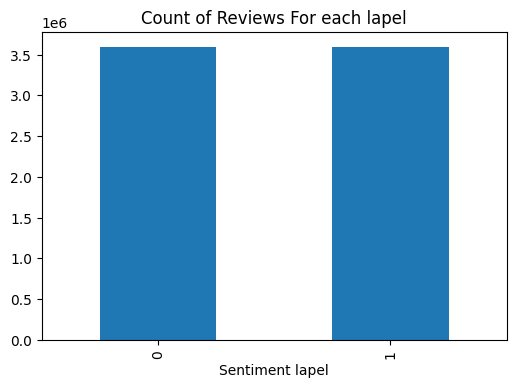

In [13]:
ax = df_amazon['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

## Podcasts Dataset

### Read Data

In [14]:
with pd.read_json('data//Podcast reviews//reviews.json', lines=True, chunksize=100000) as chunks:
    df = pd.DataFrame()  # Initialize an empty DataFrame outside the loop
    for chunk in chunks:
        df = pd.concat([df, chunk])  # Concatenate each chunk to the existing df


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607021 entries, 0 to 5607020
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   podcast_id  object             
 1   title       object             
 2   content     object             
 3   rating      int64              
 4   author_id   object             
 5   created_at  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 256.7+ MB


### Adjusting the dataset for Binary Classification

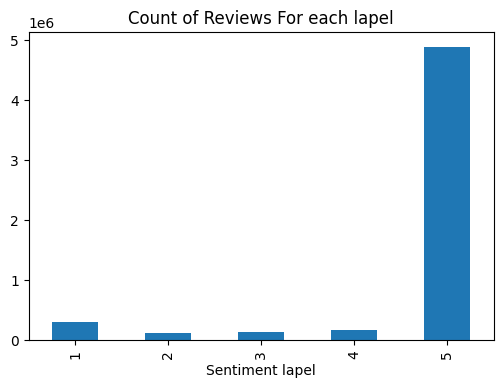

In [16]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [17]:
# Count the Nigative reviews in the Dataset
df.loc[df['rating'] == 2, 'rating'] = 1
df[df['rating'] == 1].shape[0]

419142

*Note:*
*Data is inpalanced and bayes to positive reviews*

In [18]:
# Drop rows where rating is 3 or 4
df = df.drop(df[df['rating'].isin([3, 4])].index)

*Take only 0.5m from positive reviews to balance the data set*

In [20]:
df_5 = df[df['rating'] == 5]
df_5 = df_5.sample(500000)

In [21]:
df = df.drop(df[df['rating'].isin([5])].index)
df = pd.concat([df_5, df], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919142 entries, 0 to 919141
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   podcast_id  919142 non-null  object             
 1   title       919142 non-null  object             
 2   content     919142 non-null  object             
 3   rating      919142 non-null  int64              
 4   author_id   919142 non-null  object             
 5   created_at  919142 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 42.1+ MB


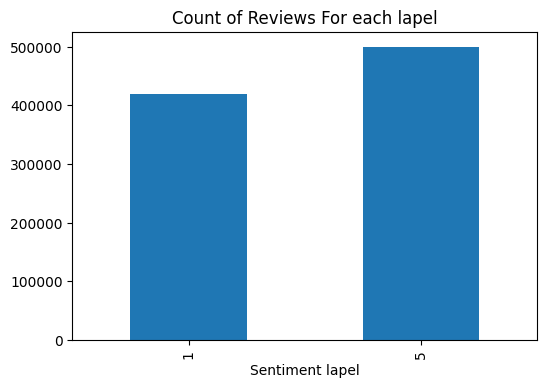

In [23]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [24]:
df['rating'] = df['rating'].replace({1: 0, 5: 1})
df = df.drop(['podcast_id', 'author_id', 'created_at'], axis=1)
df.head()

,title,content,rating
0,SO excited about this podcast!!!,I could listen to these coaches and leaders al...,1
1,A new fave,"I’m over here listening, going FUCcc. Kelley’s...",1
2,I love it 🥰,Hi there I have a question 🙋‍♂️ did you get a ...,1
3,Great podcast,These guys are funny and knowledgeable; enjoy ...,1
4,My favorite podcast!,I listen to A Lot of podcasts and this one is ...,1


In [25]:
df_title = df.drop(['content'], axis=1)
df_title = df_title.rename(columns={'title': 'content'})
df_title.head()

,content,rating
0,SO excited about this podcast!!!,1
1,A new fave,1
2,I love it 🥰,1
3,Great podcast,1
4,My favorite podcast!,1


In [26]:
df = pd.concat([df_title, df], ignore_index=True)
df = df.drop(['title'], axis=1)
df.head()

,content,rating
0,SO excited about this podcast!!!,1
1,A new fave,1
2,I love it 🥰,1
3,Great podcast,1
4,My favorite podcast!,1


In [27]:
df = df.rename(columns={'content': 'text', 'rating': 'label'})
df_podcast = df

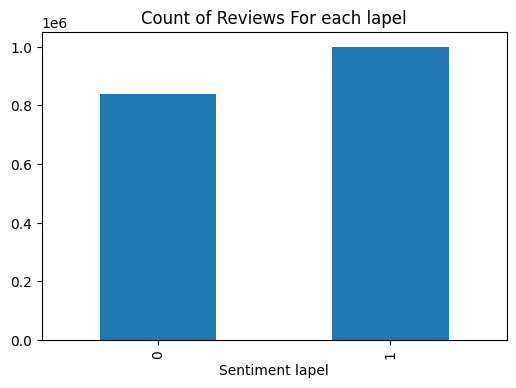

In [28]:
ax = df_podcast['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

## Twitter Dataset

In [29]:
df = pd.read_csv('data//training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", engine="python")
df.columns = ["label", "time", "date", "query", "username", "text"]
print(df.shape)

(1599999, 6)


In [30]:
df = df.drop(['time', 'date', 'query', 'username'], axis=1)

In [31]:
df['label'] = df['label'].replace({4: 1})

In [32]:
# Check for null values after dropping
print(df.isnull().sum())

# Drop null values in the data frame
df = df.dropna()

print(df.isnull().sum())

label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


In [33]:
df.head()

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1599999 non-null  int64 
 1   text    1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


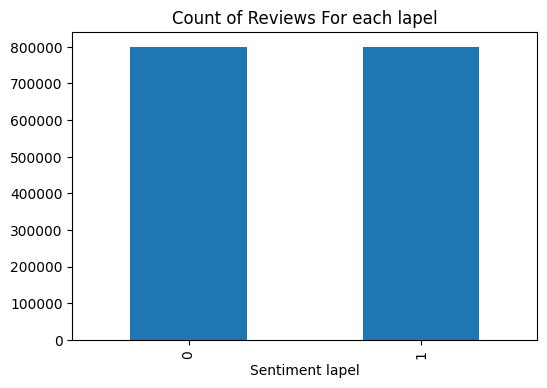

In [35]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

In [36]:
df_twitter = df

## Concatenate  The 3 Datasets

In [38]:
df_concatenated = pd.concat([df_podcast, df_amazon, df_twitter], ignore_index=True)
df_concatenated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10638074 entries, 0 to 10638073
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   label   int64 
dtypes: int64(1), object(1)
memory usage: 162.3+ MB


In [39]:
df_concatenated.head()

,text,label
0,SO excited about this podcast!!!,1
1,A new fave,1
2,I love it 🥰,1
3,Great podcast,1
4,My favorite podcast!,1


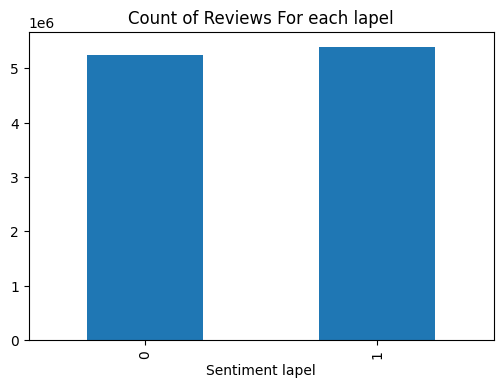

In [40]:
ax = df_concatenated['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews For each lapel',
          figsize=(6, 4))
ax.set_xlabel('Sentiment lapel')
plt.show()

# Preprocessing

In [41]:
df_concatenated.to_csv('Concatenated_Data')

In [3]:
df = pd.read_csv('Concatenated_Data.csv')

In [5]:
text = df['text'][100]
text

'Making good books even better'

In [10]:
# Check for null values after dropping
print(df.isnull().sum())

# Drop null values in the data frame
df = df.dropna()

print(df.isnull().sum())

Unnamed: 0     0
text          58
label          0
dtype: int64
Unnamed: 0    0
text          0
label         0
dtype: int64


## NLTK Preprocessing

In [7]:
# Download the 'stopwords' resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\mohamed
[nltk_data]     mowina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
import emoji
import re

# Download NLTK stopwords and WordNet (one-time download)
nltk.download('stopwords')
nltk.download('wordnet')

# Load stop words
stop_words = stopwords.words('english')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
lemmatizer = WordNetLemmatizer()

In [31]:
def nltk_bert_preprocess(text):
  """Preprocesses text using NLTK, BERT tokenizer, lemmatization"""
  # Lowercase the text
  text = text.lower()

  # Remove punctuation and URLs with regular expressions
  text = re.sub(r'[^\s]+@[^\s]+\.[^\s]+', '', text)  # remove emails (optional)
  text = re.sub(r'[0-9]+', '', text)  # remove numbers
  text = re.sub(r'[^\s]+://[^\s]+', '', text)  # remove URLs

  # Remove emojis
  text = emoji.demojize(text)

  # Lemmatization using WordNetLemmatizer
  lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])

  # Tokenize using BERT tokenizer
  tokens = tokenizer.tokenize(lemma_text)

  # Remove stop words using NLTK stopwords
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in tokens if token not in stop_words]

  # Join the filtered tokens back into a string
  processed_text = ' '.join(filtered_tokens)
  return processed_text

In [32]:
df['nltk_bert_preprocessed'] = df['text'].apply(nltk_bert_preprocess)
df.head()

,Unnamed: 0,text,label,nltk_bert_preprocessed
0,0,SO excited about this podcast!!!,1,excited podcast ! ! !
1,1,A new fave,1,new fa ##ve
2,2,I love it 🥰,1,love : smiling _ face _ _ hearts :
3,3,Great podcast,1,great podcast
4,4,My favorite podcast!,1,favorite podcast !


In [8]:
def preprocess_text(text):
  """Applies preprocessing steps to the given text."""
  # Lowercase text
  text = text.lower()

  # Remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])

  # Tokenize using BERT tokenizer
  tokens = tokenizer.tokenize(text)
  
  # Remove emojis
  text = emoji.demojize(text)

  # Remove numbers (optional)
  text = re.sub('[0-9]+', '', text)

  # Remove special characters, punctuation including %, ., and ,
  text = re.sub(r"[^\w\s!@#\$*\(\)_\+=\^:\\]", " ", text)  # Preserve negation words

  # Lemmatization (preferred)
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  # Clean URLs
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)

  # Clean Emails
  text = re.sub('@[^\s]+', ' ', text)
  
  # Stop word removal (optional)
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

In [10]:
# Load stop words
stop_words = stopwords.words('english')

# Sample text
text = df['text'][100]

# Preprocess the sample text
preprocessed_text = preprocess_text(text)
print("Preprocessed text:", preprocessed_text)

# Tokenize using BERT tokenizer (optional, replace with your desired tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.tokenize(preprocessed_text)
print("BERT tokens:", tokens)

Preprocessed text: making good book even better
BERT tokens: ['making', 'good', 'book', 'even', 'better']


In [11]:
df['text'] = df['text'].astype(str)

# Clean text
df['text'] = df['text'].apply(lambda text: preprocess_text(text))

In [33]:
# Create a new column to store the IDs
df['nltk_bert_preprocessed_ids'] = df['nltk_bert_preprocessed'].apply(lambda text: tokenizer.convert_tokens_to_ids(text.split()))
df.head()

,Unnamed: 0,text,label,nltk_bert_preprocessed,nltk_bert_preprocessed_ids
0,0,SO excited about this podcast!!!,1,excited podcast ! ! !,"[7568, 16110, 999, 999, 999]"
1,1,A new fave,1,new fa ##ve,"[2047, 6904, 3726]"
2,2,I love it 🥰,1,love : smiling _ face _ _ hearts :,"[2293, 1024, 5629, 1035, 2227, 1035, 1035, 807..."
3,3,Great podcast,1,great podcast,"[2307, 16110]"
4,4,My favorite podcast!,1,favorite podcast !,"[5440, 16110, 999]"


In [12]:
# Tokenize the preprocessed text
df['tokens'] = df['text'].apply(lambda text: tokenizer.tokenize(text))



,Unnamed: 0,text,label,tokens,input_ids
0,0,excited podcast!!!,1,"[excited, podcast, !, !, !]","[7568, 16110, 999, 999, 999]"
1,1,new fave,1,"[new, fa, ##ve]","[2047, 6904, 3726]"
2,2,love,1,[love],[2293]
3,3,great podcast,1,"[great, podcast]","[2307, 16110]"
4,4,favorite podcast!,1,"[favorite, podcast, !]","[5440, 16110, 999]"


In [34]:
# Save to pickle file
df.to_pickle('nltk_preprocessed.pkl')

" # Load from pickle file\nloaded_df = pd.read_pickle('my_dataframe.pkl') "

In [3]:
# Load from pickle file
df = pd.read_pickle('nltk_preprocessed.pkl')
df.head()

,Unnamed: 0,text,label,nltk_bert_preprocessed,nltk_bert_preprocessed_ids
0,0,SO excited about this podcast!!!,1,excited podcast ! ! !,"[7568, 16110, 999, 999, 999]"
1,1,A new fave,1,new fa ##ve,"[2047, 6904, 3726]"
2,2,I love it 🥰,1,love : smiling _ face _ _ hearts :,"[2293, 1024, 5629, 1035, 2227, 1035, 1035, 807..."
3,3,Great podcast,1,great podcast,"[2307, 16110]"
4,4,My favorite podcast!,1,favorite podcast !,"[5440, 16110, 999]"


## Spacy preprocessing

In [ ]:
import spacy
import emoji
from functools import lru_cache

nlp = spacy.load("en_core_web_sm", disable=["parser"])  # Disable parser for speed

@lru_cache(maxsize=None)  # No size limit for potentially large cache
def spacy_preprocess(text):
    if text in cache:
        return cache[text]

    text = emoji.demojize(text)
    doc = nlp(text)  # Process the entire text at once

    # Access token properties directly from the generator expression
    tokens = [token.lemma_ for token in doc if not (
    token.is_stop or  # Separate conditions using 'or'
    token.like_num or
    token.is_punct or
    token.like_url or
    token.like_email
    )]


    processed_text = ' '.join(tokens)
    cache[text] = processed_text
    return processed_text

cache = {}  # Initialize cache

# Assuming you have a DataFrame 'df' with a 'text' column
df['spacy_preprocessed'] = df['text'].apply(spacy_preprocess)


In [6]:
import spacy
import emoji

nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    # Convert emoji to text
    text = emoji.demojize(text)
    
    # Process the text using spaCy
    doc = nlp(text)
    
    # Exclude numbers, punctuation, URLs, emails, and stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop 
              and not token.like_num 
              and not token.is_punct 
              and not token.like_url 
              and not token.like_email]
    
    return ' '.join(tokens)

In [25]:
print('Original Text:',text)
print('Processed Text:',spacy_preprocess(text))

Original Text: Making good books even better
Processed Text: make good book well


In [ ]:
df['text'] = df['text'].astype(str)

# Clean text
df['spacy_preprocessed'] = df['text'].apply(lambda text: spacy_preprocess(text))

In [ ]:
def convert_to_ids(preprocessed_text):
    # Process the preprocessed text with spaCy
    doc = nlp(preprocessed_text)
    
    # Convert tokens to IDs
    token_ids = [token.orth for token in doc]
    
    return token_ids

# Apply the function to the 'spacy_preprocessed' column and store in 'spacy_ids'
df['spacy_ids'] = df['spacy_preprocessed'].apply(lambda text: convert_to_ids(text))

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Save to pickle file
df.to_pickle('spacy_preprocessed.pkl')

""" # Load from pickle file
loaded_df = pd.read_pickle('my_dataframe.pkl') """


" # Load from pickle file\nloaded_df = pd.read_pickle('my_dataframe.pkl') "

In [ ]:
df_cleaned = df[['spacy_ids', 'label']]
df_cleaned.head()

,input_ids,label
0,"[7568, 16110, 999, 999, 999]",1
1,"[2047, 6904, 3726]",1
2,[2293],1
3,"[2307, 16110]",1
4,"[5440, 16110, 999]",1


In [ ]:
unique_labels = df_cleaned['label'].unique()
unique_labels

array([1, 0], dtype=int64)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10638074 entries, 0 to 10638073
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   input_ids  object
 1   label      int64 
dtypes: int64(1), object(1)
memory usage: 162.3+ MB


# Build RNN model

In [4]:
# Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# Hyperparameters
max_len = 200
vocab_size = 50000
embedding_dim = 128
learning_rate = 0.001
dropout_rate = 0.5
num_lstm_units = 128
num_dense_units = 64

# Split data into train, validation, and test sets
X = df['nltk_bert_preprocessed_ids']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
# Convert input data to numpy arrays and pad sequences
X_train_padded = pad_sequences(X_train.values, maxlen=max_len)
X_val_padded = pad_sequences(X_val.values, maxlen=max_len)
X_test_padded = pad_sequences(X_test.values, maxlen=max_len)

## Model Arcticture

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model definition
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

# LSTM layer
model.add(LSTM(num_lstm_units, dropout=dropout_rate))

# Dense layers
model.add(Dense(num_dense_units, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(filepath='final_model_V1.h5', monitor='val_loss', save_best_only=True)

# Train the model
hist = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val),
                     callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
299195/299195 [==============================] - 9304s 31ms/step - loss: 0.3369 - accuracy: 0.8478 - val_loss: 0.3187 - val_accuracy: 0.8585
Epoch 2/10
299195/299195 [==============================] - 9484s 32ms/step - loss: 0.3264 - accuracy: 0.8539 - val_loss: 0.3185 - val_accuracy: 0.8581
Epoch 3/10
299195/299195 [==============================] - 9299s 31ms/step - loss: 0.3284 - accuracy: 0.8530 - val_loss: 0.3214 - val_accuracy: 0.8571
Epoch 4/10
138447/299195 [============>.................] - ETA: 1:19:09 - loss: 0.3303 - accuracy: 0.8522

KeyboardInterrupt: 

In [8]:
model

In [ ]:
from tensorflow.keras.models import load_model

# Path to your h5 model file
model_path = 'final_model_V1.h5'

# Load the model
model = load_model(model_path)

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

66488/66488 [==============================] - 855s 13ms/step - loss: 0.3195 - accuracy: 0.8577
Test Loss: 0.31951433420181274
Test Accuracy: 0.8577455878257751


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,539,905
Trainable params: 6,539,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
ax.plot(hist.history['loss'], color='teal', label='Training Loss')  # Rename labels
ax.plot(hist.history['val_loss'], color='orange', label='Validation Loss')

# Customize plot elements
ax.set_title('Loss Curves', fontsize=20)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='upper left', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)  # Add grid lines

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test_padded)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
model_Evaluate(model)

# Build RNN model with SpaCy preprocesing

In [ ]:
# Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
# Hyperparameters
max_len = 200
vocab_size = 50000
embedding_dim = 128
learning_rate = 0.001
dropout_rate = 0.5
num_lstm_units = 128
num_dense_units = 64

# Split data into train, validation, and test sets
X = df['spacy_ids']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
# Convert input data to numpy arrays and pad sequences
X_train_padded = pad_sequences(X_train.values, maxlen=max_len)
X_val_padded = pad_sequences(X_val.values, maxlen=max_len)
X_test_padded = pad_sequences(X_test.values, maxlen=max_len)

## Model Arcticture

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model definition
model2 = Sequential()

# Embedding layer
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

# LSTM layer
model2.add(LSTM(num_lstm_units, dropout=dropout_rate))

# Dense layers
model2.add(Dense(num_dense_units, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(filepath='final_model_V2.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model2.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val),
                     callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
299196/299196 [==============================] - 12751s 43ms/step - loss: 0.3554 - accuracy: 0.8370 - val_loss: 0.3377 - val_accuracy: 0.8467
Epoch 2/20
299196/299196 [==============================] - 55988s 187ms/step - loss: 0.3449 - accuracy: 0.8433 - val_loss: 0.3373 - val_accuracy: 0.8469
Epoch 3/20
168638/299196 [===============>..............] - ETA: 1:14:36 - loss: 0.3451 - accuracy: 0.8434

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model2.evaluate(X_test_padded, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3125/3125 [==============================] - 40s 13ms/step - loss: 0.1676 - accuracy: 0.9357
Test Loss: 0.16764774918556213
Test Accuracy: 0.935699999332428


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,539,905
Trainable params: 6,539,905
Non-trainable params: 0
_________________________________________________________________


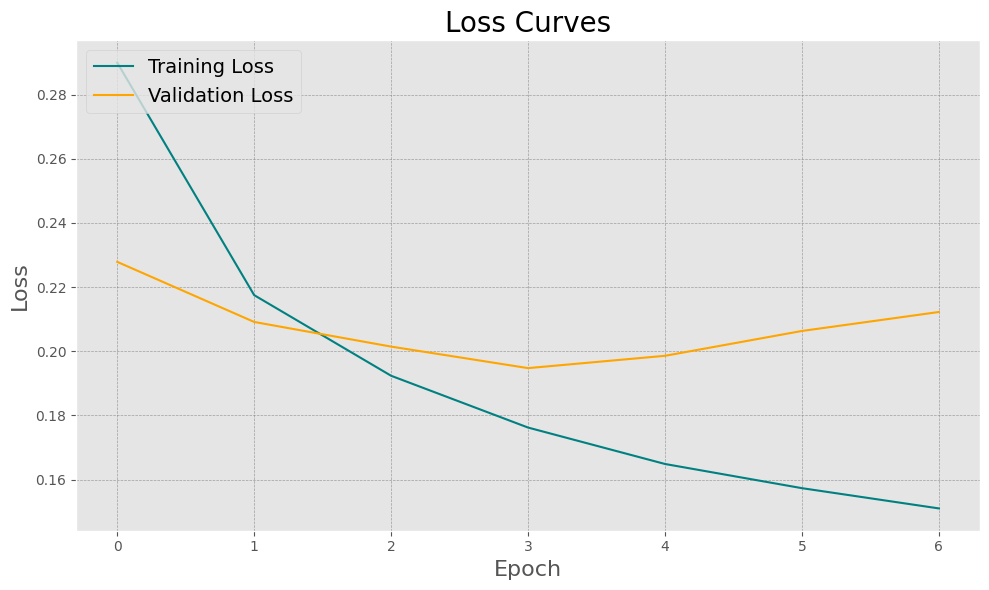

In [ ]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
ax.plot(hist.history['loss'], color='teal', label='Training Loss')  # Rename labels
ax.plot(hist.history['val_loss'], color='orange', label='Validation Loss')

# Customize plot elements
ax.set_title('Loss Curves', fontsize=20)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='upper left', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)  # Add grid lines

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
model_Evaluate(model2)

## Implemintaion

In [ ]:
from tensorflow.keras.models import load_model

# Path to your h5 model file
model_path = 'amazon_sample_model2.h5'

# Load the model
model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def predict_sentiment(text, model = model, tokenizer = tokenizer, max_len = max_len):
  """Predicts sentiment for a given text using the provided model and tokenizer.

  Args:
      text: The text to predict sentiment for (string).
      model: The trained sentiment analysis model.
      tokenizer: The tokenizer used to preprocess the text.
      max_len: The maximum sequence length for the model (integer).

  Returns:
      A tuple containing:
          - predicted_sentiment: The predicted sentiment score (float).
          - sentiment_label: The sentiment label based on a threshold (string).
  """

  # Preprocess the text
  preprocessed_text = preprocess_text(text)  # Replace with your preprocessing function

  # Tokenize the text
  tokens = tokenizer.tokenize(preprocessed_text, padding='max_length', truncation=True)

  # Convert tokens to IDs
  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # Pad the sequence (if model requires it)
  padded_input = pad_sequences([input_ids], maxlen=max_len)

  # Make the prediction
  predicted_sentiment = model.predict(padded_input)[0][0]  # Assuming single output

  # Define a threshold for sentiment classification (optional)
  threshold = 0.5  # Adjust threshold based on your model's output range

  sentiment_label = 'Positive' if predicted_sentiment > threshold else 'Negative'

  return predicted_sentiment, sentiment_label



In [ ]:
ex_text = input('Text:')

In [ ]:
#ex_text = "The first one I bought was defective. The DVD didn't work at all. I purchased it from Electronics Express and when I contacted them they were wonderful. They gave me an RMA number right away, Fedex picked it up the next day and a new one arrived 1 week later. This one is just fine. I really love the clarity of the picture. My only complaint is that in DVD mode, the sound isn't loud enough. I have it in my RV and with the A/C running, I can barely hear it. I solved the problem by running an audio out jack from the TV to the input on the RV stereo speaker system. It's very lightweight and easy to move around and store. A bonus for the RV. The remote isn't great, but it works just fine and the video/audio jacks and antenna input are easy to get to as is the DVD player. All in all, it's a great deal for the price."
predict_sentiment(ex_text)

Keyword arguments {'padding': 'max_length', 'truncation': True} not recognized.


1/1 [==============================] - 0s 39ms/step


(0.017015614, 'Negative')

# DistilBERT

In [4]:
df_sample = df.sample(1000000)
df_sample.head()

,Unnamed: 0,text,label
4799926,4799926,Twilight Sky,0
1515301,1515301,I love Star Trek and I love seeing the jokes a...,0
3185989,3185989,A documentary and nothing else,0
1410370,1410370,Inspiring and uplifting. Great information and...,1
10263886,10263886,"says TUKS, 8am OBLE Garden. http://plurk.com/...",1


In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

# Define model name (DistilBERT base uncased for classification)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Load the tokenizer and pre-trained model for sequence classification
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
from transformers import TFAutoModelForSequenceClassification, DistilBertTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

""" # Define model name (TensorFlow version)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
 """
# Load the tokenizer (works with both PyTorch and TensorFlow models)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
""" model = TFAutoModelForSequenceClassification.from_pretrained(model_name) """

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [5]:
# Check for null values after dropping
print(df_sample.isnull().sum())

# Drop null values in the data frame
df_sample = df_sample.dropna()

print(df_sample.isnull().sum())

Unnamed: 0    0
text          2
label         0
dtype: int64
Unnamed: 0    0
text          0
label         0
dtype: int64


In [18]:
max_length = 200  # Set your desired max sequence length
input_ids = []
attention_masks = []

for text in df_sample['text']:
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

input_ids = np.vstack(input_ids)
attention_masks = np.vstack(attention_masks)

In [38]:
# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, df_sample['label'].values))

In [39]:
from transformers import TFDistilBertForSequenceClassification

# Define model architecture
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [40]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [41]:
# Fine-tune the model
batch_size = 32
epochs = 3
history = model.fit(dataset.shuffle(len(df)).batch(batch_size), epochs=epochs)

Epoch 1/3


AttributeError: in user code:

    File "c:\Users\mohamed mowina\anaconda3\envs\nngpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mohamed mowina\anaconda3\envs\nngpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mohamed mowina\anaconda3\envs\nngpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mohamed mowina\anaconda3\envs\nngpu\lib\site-packages\transformers\modeling_tf_utils.py", line 1630, in train_step
        x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)

    AttributeError: module 'keras.utils' has no attribute 'unpack_x_y_sample_weight'


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer


# Preprocess text (tokenization, padding, etc.)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 200  # Set your desired max sequence length
input_ids = []
attention_masks = []

for text in df_sample['text']:
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf',
        truncation=True  # Add this line
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

: 

In [7]:
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Create TensorFlow dataset (use appropriate handling for weights)
labels = df_sample['label'].values  # Assuming labels are numerical (0 or 1)
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))
def unpack_data(x, y):
    return x, y  # Assuming no sample weights
dataset = dataset.map(unpack_data)  # Address TensorFlow version incompatibility

In [ ]:
# Define model architecture (adjust num_labels to 2)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Select appropriate loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Use BinaryCrossentropy for 2 classes
metric = tf.keras.metrics.BinaryAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])



# Inference (code snippet not provided, but adaptation is straightforward)
# ...


In [ ]:
# Fine-tune the model
batch_size = 32
epochs = 3
history = model.fit(dataset.shuffle(len(df_sample)).batch(batch_size), epochs=epochs)

# Save the trained model
model.save_pretrained('distilbert_finetuned')